# U.S. Treasury Notes and Bonds Yield Curve Forecasting


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from pandas_datareader import data as pdr
import datetime
from matplotlib import pyplot as plt

## Import data

In [3]:
# Define the start and end date of the data range
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime.today()

# Pull data from the FRED api using pandas_datareader
tickers = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
name = ['1MO', '3MO', '6MO', '1YR', '2YR', '3YR', '5YR', '7YR', '10YR', '20YR', '30YR']
df = pdr.get_data_fred(tickers, start, end).dropna()      # drop missing values
df = df.rename(columns={tickers[i]:name[i] for i in range(len(tickers))})

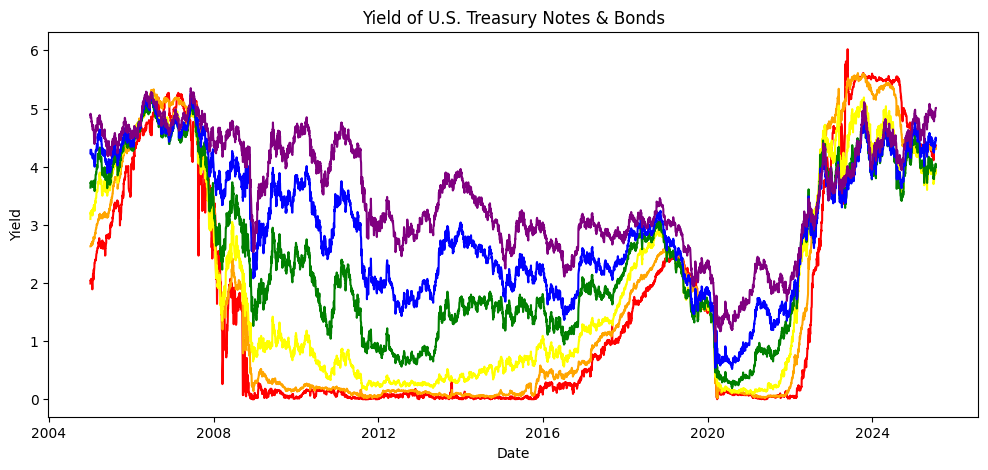

In [4]:
# Plot yields through time
plt.figure(figsize = (12,5))
plt.plot(df['1MO'], color='red')
plt.plot(df['6MO'], color='orange')
plt.plot(df['2YR'], color='yellow')
plt.plot(df['5YR'], color='green')
plt.plot(df['10YR'], color='blue')
plt.plot(df['30YR'], color='purple')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Yield of U.S. Treasury Notes & Bonds')
plt.show()

In [5]:
# Split into training and test data
train_portion = 0.9
n_train = int(len(df) * train_portion)
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]

## PCA Analysis

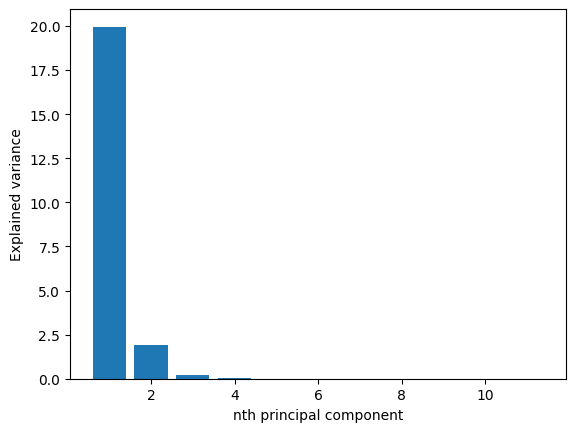

In [6]:
# Center the train data before PCA
yield_mean = df_train.mean()
df_train_c = df_train - yield_mean

# Examine the main contributing components
# Get all principal components of PCA
pca_all = PCA(n_components=df.shape[1])
pca_all.fit(df_train_c)
loadings = pca_all.components_

# Plot explained variance of each component
explained_var = pca_all.explained_variance_
plt.bar(np.arange(1,12),explained_var)
plt.xlabel('nth principal component')
plt.ylabel('Explained variance')
plt.show()


In [7]:
# Get the first three components
pca = PCA(n_components=3)
pca.fit(df_train_c)
loadings = pca.components_

# Adjust direction of components to correctly infer the dynamics
loadings[1] *= -1

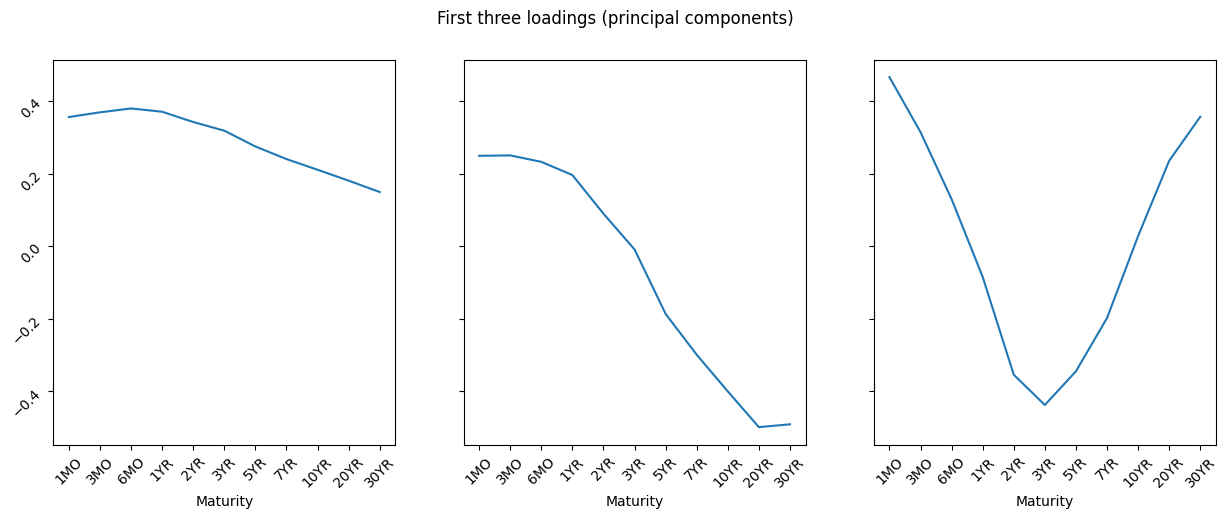

In [8]:
# Plot the first three components
fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
ax[0].plot(loadings[0])
ax[0].set_xticks(np.arange(0,11), name)
ax[0].tick_params(labelrotation=45)
ax[0].set_xlabel('Maturity')
ax[1].plot(loadings[1])
ax[1].set_xticks(np.arange(0,11), name)
ax[1].tick_params(labelrotation=45)
ax[1].set_xlabel('Maturity')
ax[2].plot(loadings[2])
ax[2].set_xticks(np.arange(0,11), name)
ax[2].tick_params(labelrotation=45)
ax[2].set_xlabel('Maturity')
fig.suptitle('First three loadings (principal components)')
plt.show()

In [9]:
# Represent the original training data in a basis of the first three loadings
scores = df_train_c.to_numpy() @ loadings.T
scores

array([[ 4.00184955, -1.68072104, -0.27291323],
       [ 4.17998661, -1.77631714, -0.32713554],
       [ 4.18300492, -1.74731257, -0.36535139],
       ...,
       [ 8.91009958,  2.14014449,  0.59622505],
       [ 8.80743973,  2.2250846 ,  0.62792492],
       [ 8.81816637,  2.27333352,  0.70906716]], shape=(4625, 3))

## Forcasting using VAR (Vector Autoregression)

In [10]:
# Use VAR (Vector Autoregression) to model the dynamics of score
var_model = VAR(scores)
maxlag = 15
var_res = var_model.fit(maxlags=maxlag, ic='aic')      # Set max la = 15
var_res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 19, Jul, 2025
Time:                     18:41:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.0825
Nobs:                     4610.00    HQIC:                  -15.2074
Log likelihood:           15723.4    FPE:                2.32310e-07
AIC:                     -15.2752    Det(Omega_mle):     2.25493e-07
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000842         0.001802            0.467           0.641
L1.y1          1.091880         0.017859           61.139           0.000
L1.y2          0.131899         0.025165            5.241           0.000
L1.y3          0.

In [15]:
# Forecast score using the fitted VAR model
score_fore = var_res.forecast(scores[-maxlag:], steps=len(df_test))

# Transform the forecasted scores back to yields
yield_fore = yield_mean + pd.DataFrame(score_fore @ loadings, columns=df.columns, index=df_test.index)
yield_fore

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2023-06-27,5.304191,5.391076,5.432285,5.196064,4.668606,4.342153,3.974300,3.823686,3.775714,3.925163,3.878246
2023-06-28,5.296306,5.384051,5.426501,5.192021,4.667375,4.342439,3.975762,3.825386,3.777009,3.926156,3.878652
2023-06-29,5.292759,5.380049,5.421928,5.187042,4.661857,4.336673,3.969970,3.819842,3.771822,3.921317,3.874548
2023-06-30,5.293516,5.378835,5.418227,5.180725,4.652007,4.325406,3.958934,3.810097,3.764280,3.915799,3.871099
2023-07-03,5.304196,5.388039,5.425427,5.185252,4.652512,4.323985,3.956634,3.808105,3.763589,3.916227,3.872559
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-11,3.770384,3.862815,3.950175,3.852225,3.626749,3.522800,3.483276,3.535686,3.636328,3.938438,3.939484
2025-07-14,3.768157,3.860567,3.947953,3.850159,3.625048,3.521378,3.482287,3.534982,3.635843,3.938177,3.939330
2025-07-15,3.765931,3.858320,3.945731,3.848094,3.623348,3.519956,3.481298,3.534277,3.635358,3.937915,3.939176


In [16]:
# Compare the forecasted yields with the test data

# Mean square error
MSE = np.mean(np.sum((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=1))
print(f'Mean Square Error : {MSE}')

Mean Square Error : 3.342678733602599


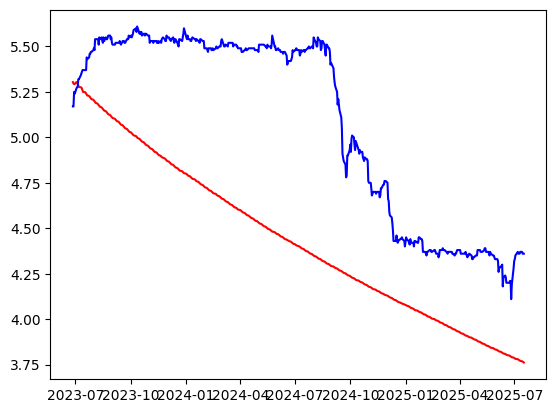

In [18]:
# Plot the forecasted vs actual 1-month yield
plt.plot(yield_fore['1MO'], color='red')
plt.plot(df_test['1MO'], color='blue')
plt.show()